# Case study: Classification of shapes

This notebook explains how to use `giotto-tda` to be able to classify topologically different high-dimensional spaces.

If you are looking at a static version of this notebook and would like to run its contents, head over to [github](https://github.com/giotto-ai/giotto-tda/blob/master/examples/classifying_shapes.ipynb).

**License: AGPLv3**

## Import libraries
The first step consists in importing relevant `giotto-tda` components and other useful libraries or modules.

In [1]:
# Importing libraries
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy

import numpy as np

from gtda.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Plotting functions
from gtda.plotting import plot_diagram, plot_point_cloud, plot_heatmap

## Sampling orientable surfaces

We are going to consider three classical topological spaces: the circle, the 2-torus and the 2-sphere.
The purpose of this tutorial is to go through the most famous topological spaces and compute their homology groups.

Each of the topological spaces we are going to encounter will be sampled. The resulting point cloud will be the input of the *persistent homology pipeline*. The first step is to apply the Vietoris–Rips technique to the point cloud. Finally, the persistent homology groups will be computed.

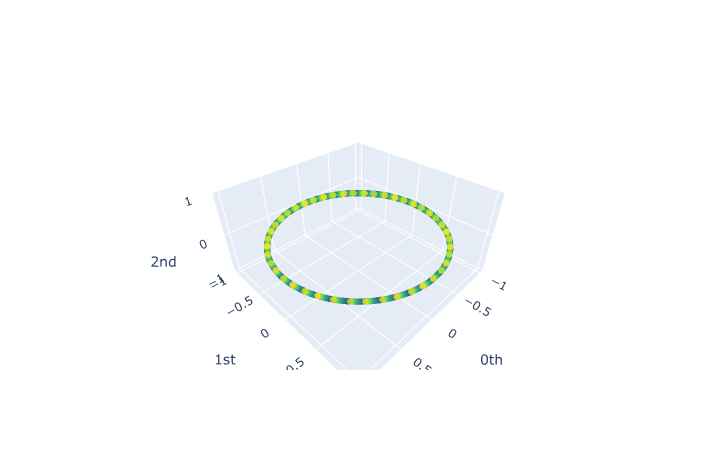

In [3]:
# Representing the circle in 3d with parametric equations.
circle = np.asarray([[np.sin(t),np.cos(t),0] for t in range(400)])
plot_point_cloud(circle)

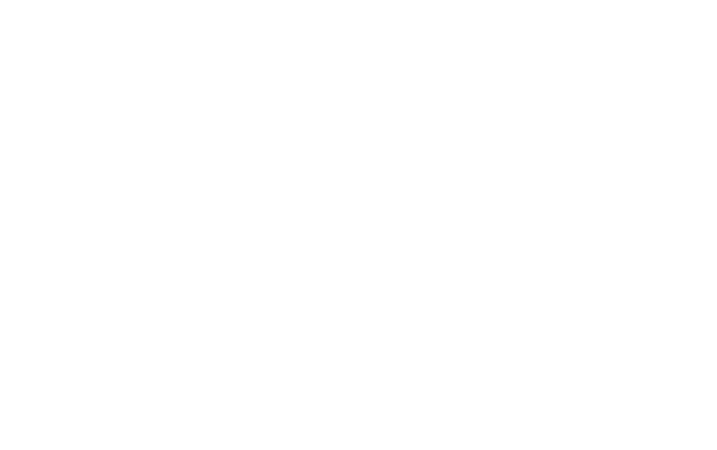

In [4]:
# Representing the sphere in 3d with parametric equations
sphere = np.asarray([[np.cos(s)*np.cos(t),np.cos(s)*np.sin(t),np.sin(s)] for t in range(20) for s in range(20)])
plot_point_cloud(sphere)

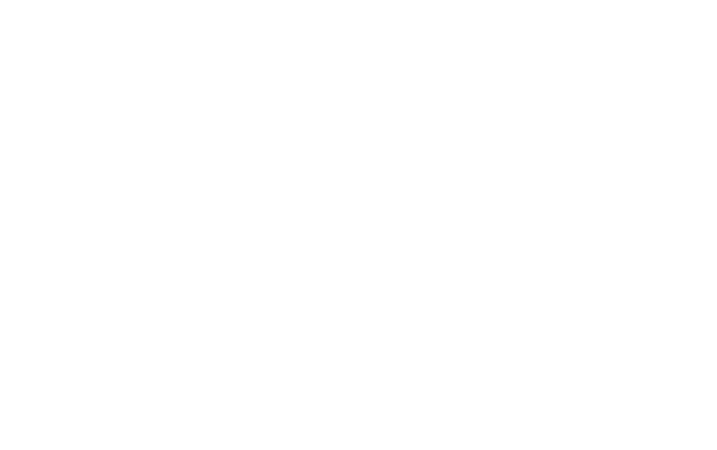

In [5]:
# Representing the torus in 3d with parametric equations
torus = np.asarray([[(2+np.cos(s))*np.cos(t),(2+np.cos(s))*np.sin(t),np.sin(s)] for t in range(20) for s in range(20)])
plot_point_cloud(torus)

In [7]:
# Saving the results into an array
topological_spaces = np.asarray([circle,sphere,torus])

## Computing persistent homology

In the next section we will use giotto-tda to compute the persistent homology groups of the topological spaces we just constructed.

We will use the Vietoris–Rips technique to generate a filtration out of a point cloud:

![SegmentLocal](https://miro.medium.com/max/1200/1*w3BiQI1OX93KXcezctRQTQ.gif "segment")

In [8]:
# The homology ranks we choose to consider
homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=10, homology_dimensions=homology_dimensions)

# Array of persistence diagrams, one per point cloud in the input
diagrams = VR.fit_transform(topological_spaces)
print(f'diagrams.shape = {diagrams.shape}')

diagrams.shape = (3, 865, 3)


## Persistence diagrams

The topological information of the point cloud is synthesised in the persistence diagram. The horizontal axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which a homological generator dies.

The generators of the homology groups (at given rank) are colored differently.

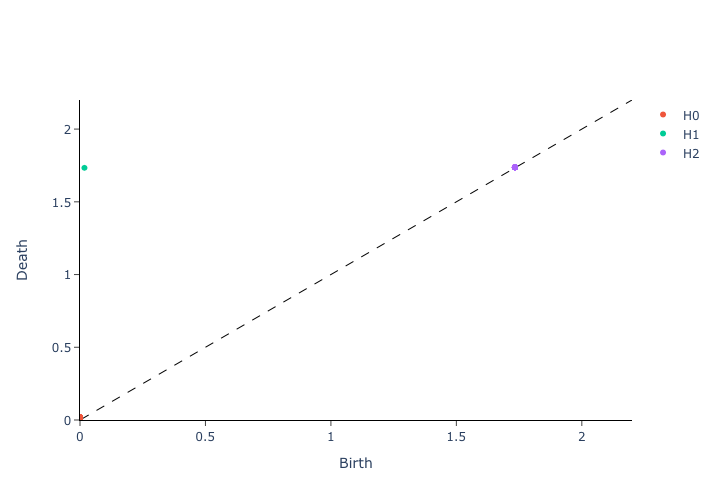

In [9]:
# Plotting the persistence diagram of the circle
plot_diagram(diagrams[0])

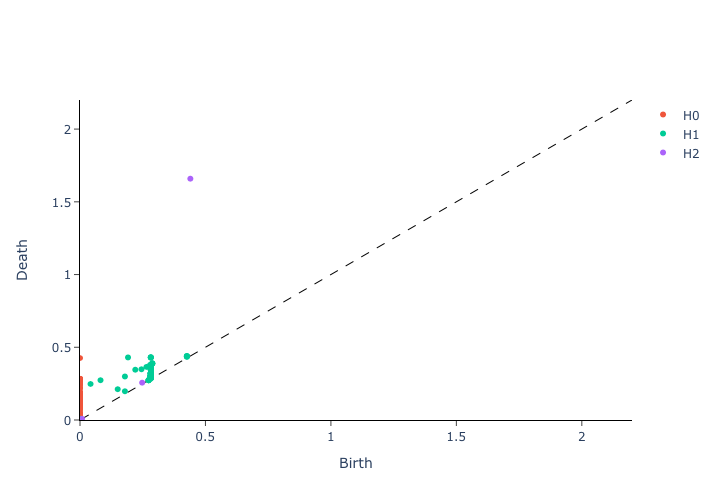

In [10]:
# Plotting the persistence diagram of the sphere
plot_diagram(diagrams[1])

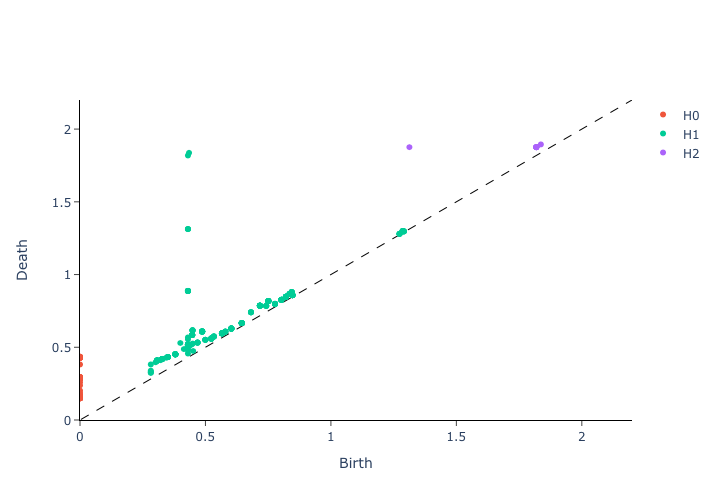

In [11]:
# plotting the persistence diagram of the torus
plot_diagram(diagrams[2])

## Conclusion of the first part

As you can see from the persistence diagrams, all the betti numbers were found. Some other persistent generators are also appearing, depending on how dense the sampling is and how much noise there is. For example, we see a rather neat persistence diagram over the Torus bottle (we see two persistent generators for $H_1$ and one persistent generator for $H_2$). Notice though that there are other persistent $H_1$ generators, possibly due to the non-uniform sampling method we used for the torus.

On the other hand, the persistence diagram for the circle is as perfect as it could be: one unique generator of $H_1$ and no other persistent generator, as expected.

## Classification of noisy orientable surfaces
In the next section we generate hundreds of noisy spheres and noisy tori. The effect of noise is to displace the points sampling the aforementioned surfaces by a random amount in a random direction.

The Vietoris–Rips algorithm is used to compute persistence diagrams. Afterwards, from each diagram, the *persistence entropy* is computed.

A simple linear classifier is then applied to the 3D-space of entropies to classify shapes.

In [ ]:
# Building dataset
n_train = 10
n_range = 15
eps = 0.3

train_Xs = [np.asarray([[np.cos(s)*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),np.cos(s)*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
train_ys = np.zeros(n_train)
train_Xt = [np.asarray([[(2+np.cos(s))*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),(2+np.cos(s))*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
train_yt = np.ones(n_train)

# Training set
train_X = np.concatenate((train_Xs, train_Xt))
train_y = np.concatenate((train_ys, train_yt))

test_Xs = [np.asarray([[np.cos(s)*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),np.cos(s)*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
test_ys = np.zeros(n_train)
test_Xt = [np.asarray([[(2+np.cos(s))*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),(2+np.cos(s))*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
test_yt = np.ones(n_train)


# Test set
test_X = np.concatenate((test_Xs, test_Xt))
test_y = np.concatenate((test_ys, test_yt))

In [ ]:
# Build persistence diagrams

# The homology ranks we choose to consider
homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=10, homology_dimensions=homology_dimensions)

# List of all the time-ordered persistence diagrams obtained from the list of correlation matrices
train_diagrams = VR.fit_transform(train_X)
test_diagrams = VR.transform(test_X)

## Extract and plot persistent entropies

In [ ]:
# Extract vector features from diagrams: persistence entropy
PE = PersistenceEntropy()
X_train = PE.fit_transform(train_diagrams)
X_test = PE.transform(test_diagrams)

In [ ]:
plot_point_cloud(X_train)

In [ ]:
# Training logistic regression
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, train_y)
# Score
LR.score(X_test, test_y)

## Generating non-orientable surfaces

We are going to consider different classical shapes: the real projective space and the Klein bottle.
The purpose of the second part of the tutorial is to define shapes via a distance matrix. We also add noise to the distance matrix: the main reason is not to have overlapping points in the persistence diagram.

Each of the topological spaces we are going to encounter will be sampled discretely. Afterwards, the Vietoris–Rips technique will be applied to the surface and the persistent homology groups will be computed.

In [ ]:
# Compute the adjacency matrix of the grid points, with boundaries identified as in the real projective space
from sklearn.utils.graph_shortest_path import graph_shortest_path

# This functions prepares the grid matrix with boundary identification
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # vertical twisted boundary identification
            if c == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # horizontal twisted boundary identification
            if r == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
                
    return M

M = make_matrix(20,20)

# Compute the distance matrix of the points over the Klein bottle

rp2 = graph_shortest_path(M)

# Plot of the distance matrix
plot_heatmap(rp2, colorscale='viridis')

In [ ]:
# Compute the adjacency matrix of the grid points, with boundaries identified as in the Klein bottle
from sklearn.utils.graph_shortest_path import graph_shortest_path

# This functions prepares the grid matrix with boundary identification
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # vertical boundary identification
            if c == 0: M[i+cols-1,i] = M[i,i+cols-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # horizontal twisted boundary identification
            if r == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
                
    return M

M = make_matrix(20,20)

# computing the distance matrix of the points over the Klein bottle

klein = graph_shortest_path(M)

# Plot of the distance matrix
plot_heatmap(klein, colorscale='viridis')

In [ ]:
# Saving the results into an array
topological_spaces_mat = np.asarray([rp2, klein])

## Computing persistent homology

In the next section we will use `giotto-tda` to compute the persistent homology groups of the topological spaces we just constructed.

In [ ]:
# the homology ranks we choose to consider
homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(
    metric='precomputed', max_edge_length=np.inf, homology_dimensions=homology_dimensions)

# List of all the time-ordered persistence diagrams obtained from the list of correlation matrices
diagrams = VR.fit_transform(topological_spaces_mat)

## Persistence diagrams

The topological information of the point cloud is synthesised in the persistence diagram. The horizontal axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.

The generators of the homology groups (at given rank) are colored differently.

In [ ]:
# Plotting the persistence diagram of the projective space
plot_diagram(diagrams[0])

In [ ]:
# Plotting the persistence diagram of the Klein bottle
plot_diagram(diagrams[1])

## Conclusion

As you can see from the persistence diagrams, all the Betti numbers were found. Some other persistent generators are also appearing, depending on how dense the sampling is and how much noise there is.

For example, we see a rather neat persistence diagram over the Klein bottle (we see two persistent generators for $H_1$ and one persistent generator for $H_2$). Notice that all these homology groups are computed over the field $\mathbb{F}_2$.